In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata2
import math
import string
import tokenize
import sklearn
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.naive_bayes import MultinomialNB
from string import digits
from xml.dom import minidom
from unidecode import unidecode
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud

stop_words = stopwords.words('spanish')
newStopWords = ['dr','dra','etc','bn','ud','u','ag','si','no','rt','q','m','bb','tan','aun','cr','tal','segun','w','lab','aca','wew','av','ah','cll','km','tm','ht','mk','xs','xxl','xl','xxx','reee','nls','kr']
stop_words.extend(newStopWords)
data=pd.read_csv("ScoreTotalData.csv")
sbEsp = SnowballStemmer('spanish')
#data.head()

In [2]:
data.Sentiment.value_counts()

2    13954
1     7292
3     3230
4     1355
5      425
Name: Sentiment, dtype: int64

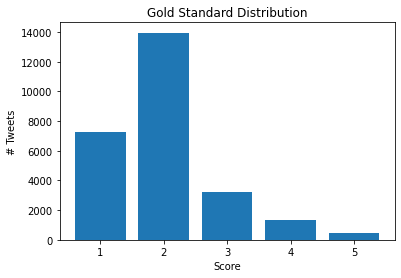

In [3]:
Sentiment_count=data.groupby('Sentiment').count()
fig, ax = plt.subplots()
plt.bar(Sentiment_count.index.values, Sentiment_count['Tweet'])
ax.set(xlabel='Score', ylabel='# Tweets',
       title='Gold Standard Distribution')
fig.savefig("distGoldStandard.jpeg")
plt.show()


In [4]:
# Preprocesamiento
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')   
    return text

# Eliminación de Hashtags y menciones
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

# Eliminación de puntuacion, numeros y conversión del texto a minúsculas
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    for digits in string.digits:
        text = text.replace(digits,'')
    text = text.lower()
    return text

def remove_punct(strin):
    strin = strin.translate(str.maketrans('','',string.punctuation));
    strin = strin.translate(str.maketrans('','',string.digits));
    return strin;

#Normalizar: eliminar diéresis, acentos, y otros caracteres similares.
def normunicode_data(strin):
    #print(strin)
    return unicodedata2.normalize('NFKD', strin).encode('ASCII', 'ignore').decode("utf-8").lower()

def proc_str(strin):
    return remove_punct(normunicode_data(strin));

def tok_cln(text):
    return set(nltk.wordpunct_tokenize(text)).difference(stop_words)

def preprocessing(text):
    text= text.apply(strip_links)
    text= text.apply(strip_all_entities)
    text= text.apply(remove_punct)
    text = text.apply(normunicode_data)
    
    return text

data.Tweet=preprocessing(data["Tweet"])
print(data.Tweet)

0        hemos impulsado la marcacion de bicicletas com...
1        desarticulada banda dedicada al hurto de empre...
2        alguna vez ha sido victima de robo en los buse...
3        estas son las victimas detras de un bicicleta ...
4        en lo que va de  se han denunciado   casos de ...
                               ...                        
26251    l a esta hora donde estan las ayudas de la alc...
26252    si lo que preocupa es el aumento en la violenc...
26253    ayuda en el barrio belalcazar se fue la luz un...
26254    en plena cuarentena multitudinario grupo violo...
26255    subsidios para empleados para habitantes de ca...
Name: Tweet, Length: 26256, dtype: object


In [5]:
def stemm_data(strin):
    stemmer = SnowballStemmer("spanish");
    return stemmer.stem(strin)  

In [6]:
def proc_string(strin,setData):
    resp = set([]);
    for data in tok_cln(proc_str(strin)):
        tm  = stemm_data(data)
        #tm = data
        resp.add(tm)
        if tm in setData:
            setData[tm].add(data)
        else:
            setData[tm] = set([data])
    return ', '.join(resp);



There are 2929967 words in the combination of all review.


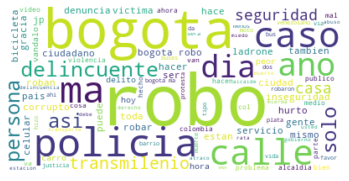

In [10]:
token_clear = data.Tweet.apply(tok_cln)
out = [item for t in token_clear for item in t]
outpd=pd.DataFrame(out, columns=['wordst'])
outpd.head()
text=" ".join(review for review in outpd.wordst)
print ("There are {} words in the combination of all review.".format(len(text)))

wordcloud = WordCloud(max_words=100,background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('freqDistwordcloud.jpeg');


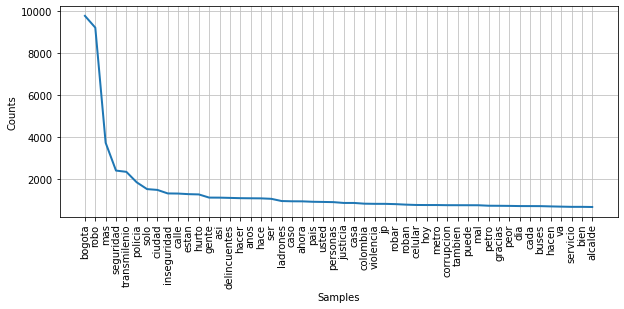

In [12]:
def freq_dist_tok(strin):
    token_clear = strin.apply(tok_cln)
    out = [item for t in token_clear for item in t] 
    fig = plt.figure(figsize = (10,4))
    plt.gcf().subplots_adjust(bottom=0.15)
    fdist = FreqDist(out)
    fdist.plot(50,cumulative=False)
    return fig.savefig('freqDist.eps', bbox_inches = "tight")

freq_dist_tok(data.Tweet)

In [13]:
def df2tdm(df,titleColumn,setData):
    listData = [];
    for idx in data.index:        
        listData.append(proc_string(data[titleColumn][idx],setData));
    return listData;

def getDictionary_BOW(dfpp): 
    setData = {}
    stinProc = df2tdm(dfpp,'Tweet',setData);
    cv =  CountVectorizer();    
    cv_fit = cv.fit_transform(stinProc);       
    cvCount =  CountVectorizer(cv.vocabulary_);
    # computes the vectorial representation of the CIE10    
    cv_fitCount = cvCount.fit_transform(stinProc);        
    features = cvCount.get_feature_names();    
    return cv,cv_fitCount,features,setData

def getDictionary_TFIDF(dfpp): 
    setData = {}
    stinProc = df2tdm(dfpp,'Tweet',setData);
    cv =  TfidfVectorizer();    
    cv_fit = cv.fit_transform(stinProc);       
    cvCount =  TfidfVectorizer(cv.vocabulary_);
    # computes the vectorial representation of the CIE10    
    cv_fitCount = cvCount.fit_transform(stinProc);        
    features = cvCount.get_feature_names();    
    return cv,cv_fitCount,features,setData

dfpp = data['Sentiment']
BOW_cvQuery_fit,BOW_cv_fitCount,BOW_features,BOW_origTerms = getDictionary_BOW(dfpp)
TFIDF_cvQuery_fit,TFIDF_cv_fitCount,TFIDF_features,TFIDF_origTerms = getDictionary_TFIDF(dfpp)

In [15]:
from sklearn.model_selection import LeaveOneOut
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

#kf = KFold(n_splits=30) # Define the split - into folds 
kf = KFold(n_splits=50, random_state=None, shuffle=False)
def kfold_metrics(model,X,y):
    accuracy_metr=[]
    precision_metr=[]
    f1_metr=[]
    recall_metr=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = model.fit(X_train, y_train)
        predicted= clf.predict(X_test)
        acc=metrics.accuracy_score(y_test, predicted)
        prec=metrics.precision_score(y_test, predicted,average='weighted', zero_division=1)
        f1sc=metrics.f1_score(y_test, predicted, average='weighted')
        rec=metrics.recall_score(y_test, predicted,average='weighted',zero_division=1)
        accuracy_metr.append(acc)
        precision_metr.append(prec)
        f1_metr.append(f1sc)
        recall_metr.append(rec)
    return accuracy_metr,precision_metr,f1_metr,recall_metr



In [16]:
acc_BOW_MNB,prec_BOW_MNB,f1_BOW_MNB,recall_BOW_MNB=kfold_metrics(MultinomialNB(),BOW_cv_fitCount,data['Sentiment']);
acc_TFIDF_MNB,prec_TFIDF_MNB,f1_TFIDF_MNB,recall_TFIDF_MNB=kfold_metrics(MultinomialNB(),TFIDF_cv_fitCount,data['Sentiment']);

In [17]:
acc_BOW_LR,prec_BOW_LR,f1_BOW_LR,recall_BOW_LR=kfold_metrics(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'),BOW_cv_fitCount,data['Sentiment']);
acc_TFIDF_LR,prec_TFIDF_LR,f1_TFIDF_LR,recall_TFIDF_LR=kfold_metrics(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'),TFIDF_cv_fitCount,data['Sentiment']);

In [18]:
acc_BOW_BNB,prec_BOW_BNB,f1_BOW_BNB,recall_BOW_BNB=kfold_metrics(BernoulliNB(),BOW_cv_fitCount,data['Sentiment']);
acc_TFIDF_BNB,prec_TFIDF_BNB,f1_TFIDF_BNB,recall_TFIDF_BNB=kfold_metrics(BernoulliNB(),TFIDF_cv_fitCount,data['Sentiment']);

In [20]:
acc_BOW_SGD,prec_BOW_SGD,f1_BOW_SGD,recall_BOW_SGD=kfold_metrics(SGDClassifier(loss="log", max_iter=8),BOW_cv_fitCount,data['Sentiment']);
acc_TFIDF_SGD,prec_TFIDF_SGD,f1_TFIDF_SGD,recall_TFIDF_SGD=kfold_metrics(SGDClassifier(loss="log", max_iter=8),TFIDF_cv_fitCount,data['Sentiment']);

In [21]:
import plotly.express as px
import plotly.graph_objects as go

In [22]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

In [24]:
fig = go.Figure()
fig.add_trace(go.Violin(y=acc_BOW_MNB, scalegroup='BOW', 
                            pointpos=1.4,line_color='green',x0='Accuracy',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=prec_BOW_MNB, scalegroup='BOW', 
                            pointpos=1.4,line_color='teal',x0='Precision',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=f1_BOW_MNB, scalegroup='BOW',
                            pointpos=1.4,line_color='darkred', x0='F1 Score',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=recall_BOW_MNB, scalegroup='BOW',
                            pointpos=1.4,line_color='darkmagenta',x0='Recall',box_visible=True,meanline_visible=True))
#fig.add_trace(go.Scatter(y=[0.43], x0="Accuracy", marker=dict(color="crimson", size=12),mode="markers",name="Simple Score"))
fig.update_traces(meanline_visible=True, points='all', jitter=0.05, scalemode='count')
fig.update_layout(title_text='Multinomial Naive Bayes',violingap=0, violingroupgap=0.6, violinmode='overlay')
fig.add_trace(go.Scatter(x=['Accuracy'], y=[0.3815], marker = dict(color='blue', size=10), mode="markers", name="Lexicon Simple"))
fig.add_trace(go.Scatter(x=['Precision'], y=[0.3982], marker = dict(color='blue', size=10), mode="markers", name="Lexicon Simple"))
fig.add_trace(go.Scatter(x=['F1 Score'], y=[0.3815], marker = dict(color='blue', size=10), mode="markers", name="Lexicon Simple"))
fig.add_trace(go.Scatter(x=['Recall'], y=[0.3835], marker = dict(color='blue', size=10), mode="markers", name="Lexicon Simple"))
fig.add_trace(go.Scatter(x=['Accuracy'], y=[0.4174], marker = dict(color='gold', size=10), mode="markers", name="Lexicon polarity"))
fig.add_trace(go.Scatter(x=['Precision'], y=[0.4463], marker = dict(color='gold', size=10), mode="markers", name="Lexicon polarity"))
fig.add_trace(go.Scatter(x=['F1 Score'], y=[0.4174], marker = dict(color='gold', size=10), mode="markers", name="Lexicon polarity"))
fig.add_trace(go.Scatter(x=['Recall'], y=[0.3592], marker = dict(color='gold', size=10), mode="markers", name="Lexicon polarity"))
fig.write_image("images/MNB.jpeg")
fig.show()

In [25]:
def plots_metrics(metric_BOW_SGD, metric_TFIDF_SGD, metric_BOW_BNB, metric_TFIDF_BNB, 
                  metric_BOW_LR, metric_TFIDF_LR,metric_BOW_MNB, metric_TFIDF_MNB, measure, 
                  lexicon_data1, lexicon_data2):
    fig = go.Figure()
    fig.add_trace(go.Violin(y=metric_BOW_SGD, scalegroup='BOW', name='BOW SGD',side='negative',
                            pointpos=-1.4,line_color='green',x0='SGD Classifier'))
    fig.add_trace(go.Violin(y=metric_TFIDF_SGD, scalegroup='TFIDF', name='TFIDF SGD',side='positive', 
                            pointpos=1.4,line_color='lightseagreen',x0='SGD Classifier'))
    fig.add_trace(go.Violin(y=metric_BOW_BNB, scalegroup='BOW', name='BOW BNB',side='negative',
                            pointpos=-1.4,line_color='red', x0='Bernoulli NB'))
    fig.add_trace(go.Violin(y=metric_TFIDF_BNB, scalegroup='TFIDF', name='TFIDF BNB',side='positive',
                            pointpos=1.4,line_color='darkmagenta',x0='Bernoulli NB'))
    fig.add_trace(go.Violin(y=metric_BOW_LR, scalegroup='BOW', name='BOW LR',side='negative',
                            pointpos=-1.4,line_color='blue',x0='Logistic Regresion'))
    fig.add_trace(go.Violin(y=metric_TFIDF_LR, scalegroup='TFIDF', name='TFIDF LR',side='positive',
                            pointpos=1.4,line_color='darkblue', x0='Logistic Regresion'))
    fig.add_trace(go.Violin(y=metric_BOW_MNB, scalegroup='BOW', name='BOW MNB',side='negative',
                            pointpos=-1.4,line_color='black', x0='Multinomial NB'))
    fig.add_trace(go.Violin(y=metric_TFIDF_MNB, name='TFIDF MNB',side='positive',
                            pointpos=1.4,line_color='gray', x0='Multinomial NB'))
    fig.update_traces(meanline_visible=True, points='all', jitter=0.05, scalemode='count')
    fig.update_layout(title_text=measure,violingap=0, violingroupgap=0.6, violinmode='overlay')
    fig.add_trace(go.Scatter(x=['SGD Classifier', 'Multinomial NB'], y=[lexicon_data1,lexicon_data1], line = dict(color='darkslategrey', dash='dash'), name="Lexicon Simple"))
    fig.add_trace(go.Scatter(x=['SGD Classifier', 'Multinomial NB'], y=[lexicon_data2,lexicon_data2], line = dict(color='darkslateblue', dash='dot'), name="Lexicon Polarity"))
    fig.write_image("images/"+measure+".eps")
    fig.show()



In [26]:
plots_metrics(acc_BOW_SGD, acc_TFIDF_SGD, acc_BOW_BNB, acc_TFIDF_BNB, acc_BOW_LR, acc_TFIDF_LR,
                 acc_BOW_MNB, acc_TFIDF_MNB, "Accuracy",0.3815,0.4174)

In [27]:
plots_metrics(prec_BOW_SGD, prec_TFIDF_SGD, prec_BOW_BNB, prec_TFIDF_BNB, prec_BOW_LR, prec_TFIDF_LR,
                 prec_BOW_MNB, prec_TFIDF_MNB, "Precision",0.3987,0.4463)

In [28]:
plots_metrics(f1_BOW_SGD, f1_TFIDF_SGD, f1_BOW_BNB, f1_TFIDF_BNB, f1_BOW_LR, f1_TFIDF_LR,
                 f1_BOW_MNB, f1_TFIDF_MNB, "F1",0.3835,0.3592)

In [29]:
plots_metrics(recall_BOW_SGD, recall_TFIDF_SGD, recall_BOW_BNB, recall_TFIDF_BNB, recall_BOW_LR, recall_TFIDF_LR,
                 recall_BOW_MNB, recall_TFIDF_MNB, "Recall",0.3815,0.4174)

In [30]:
def first_quantile(metric):
    q1=np.quantile(metric,0.25)
    q1_metric = [x for x in metric if x < q1]
    return q1_metric

def plots_metrics_q1(metric_BOW_SGD, metric_TFIDF_SGD, metric_BOW_BNB, metric_TFIDF_BNB, 
                  metric_BOW_LR, metric_TFIDF_LR,metric_BOW_MNB, metric_TFIDF_MNB, measure):
    fig = go.Figure()
    fig.add_trace(go.Violin(y=metric_BOW_SGD, scalegroup='BOW', name='BOW SGD',side='negative',
                            pointpos=-1.4,line_color='green',x0='SGD Classifier'))
    fig.add_trace(go.Violin(y=metric_TFIDF_SGD, scalegroup='TFIDF', name='TFIDF SGD',side='positive', 
                            pointpos=1.4,line_color='lightseagreen',x0='SGD Classifier'))
    fig.add_trace(go.Violin(y=metric_BOW_BNB, scalegroup='BOW', name='BOW BNB',side='negative',
                            pointpos=-1.4,line_color='red', x0='Bernoulli NB'))
    fig.add_trace(go.Violin(y=metric_TFIDF_BNB, scalegroup='TFIDF', name='TFIDF BNB',side='positive',
                            pointpos=1.4,line_color='darkmagenta',x0='Bernoulli NB'))
    fig.add_trace(go.Violin(y=metric_BOW_LR, scalegroup='BOW', name='BOW LR',side='negative',
                            pointpos=-1.4,line_color='blue',x0='Logistic Regresion'))
    fig.add_trace(go.Violin(y=metric_TFIDF_LR, scalegroup='TFIDF', name='TFIDF LR',side='positive',
                            pointpos=1.4,line_color='darkblue', x0='Logistic Regresion'))
    fig.add_trace(go.Violin(y=metric_BOW_MNB, scalegroup='BOW', name='BOW MNB',side='negative',
                            pointpos=-1.4,line_color='black', x0='Multinomial NB'))
    fig.add_trace(go.Violin(y=metric_TFIDF_MNB, name='TFIDF MNB',side='positive',
                            pointpos=1.4,line_color='gray', x0='Multinomial NB'))
    fig.update_traces(meanline_visible=True, points='all', jitter=0.05, scalemode='count')
    fig.update_layout(title_text=measure,violingap=0, violingroupgap=0.6, violinmode='overlay')
    fig.write_image("images/"+measure+"_q1.svg")
    fig.show()


def dataframe_metrics_q1(BOW_SGD,TFIDF_SGD,BOW_BNB,TFIDF_BNB,
                         BOW_LR,TFIDF_LR,BOW_MNB,TFIDF_MNB,measure):
    q1_BOW_SGD=first_quantile(BOW_SGD)
    q1_TFIDF_SGD=first_quantile(TFIDF_SGD)
    q1_BOW_BNB=first_quantile(BOW_BNB)
    q1_TFIDF_BNB=first_quantile(TFIDF_BNB)
    q1_BOW_LR=first_quantile(BOW_LR)
    q1_TFIDF_LR=first_quantile(TFIDF_LR)
    q1_BOW_MNB=first_quantile(BOW_MNB)
    q1_TFIDF_MNB=first_quantile(TFIDF_MNB)
    plots_metrics_q1(q1_BOW_SGD, q1_TFIDF_SGD, q1_BOW_BNB, q1_TFIDF_BNB, 
                  q1_BOW_LR, q1_TFIDF_LR,q1_BOW_MNB, q1_TFIDF_MNB, measure)
    

In [31]:
dataframe_metrics_q1(acc_BOW_SGD, acc_TFIDF_SGD, acc_BOW_BNB, acc_TFIDF_BNB, acc_BOW_LR, acc_TFIDF_LR,
                 acc_BOW_MNB, acc_TFIDF_MNB, "Accuracy")

In [32]:
dataframe_metrics_q1(prec_BOW_SGD, prec_TFIDF_SGD, prec_BOW_BNB, prec_TFIDF_BNB, prec_BOW_LR, prec_TFIDF_LR,
                 prec_BOW_MNB, prec_TFIDF_MNB, "Precision")

In [33]:
dataframe_metrics_q1(f1_BOW_SGD, f1_TFIDF_SGD, f1_BOW_BNB, f1_TFIDF_BNB, f1_BOW_LR, f1_TFIDF_LR,
                 f1_BOW_MNB, f1_TFIDF_MNB, "F1")

In [34]:
dataframe_metrics_q1(recall_BOW_SGD, recall_TFIDF_SGD, recall_BOW_BNB, recall_TFIDF_BNB, recall_BOW_LR, recall_TFIDF_LR,
                 recall_BOW_MNB, recall_TFIDF_MNB, "Recall")

In [8]:
import lime
import lime.lime_tabular

X=BOW_cv_fitCount
y=data['Sentiment']

for train_index, test_index in kf.split(BOW_cv_fitCount):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
 
    clf = MultinomialNB().fit(X_train, y_train)
    predicted= clf.predict(X_test)
    
from lime.lime_text import LimeTextExplainer
from lime import lime_text
from sklearn.pipeline import make_pipeline
rf = MultinomialNB()
rf.fit(X_train, y_train)
cv = BOW_cvQuery_fit
c = make_pipeline(cv, rf)

class_names=['1','2','3','4','5']
explainer = LimeTextExplainer(class_names=class_names)

idx =0
exp = explainer.explain_instance(data.Tweet[idx], c.predict_proba, num_features=5,top_labels=5)

print('True class: %s' % data.Tweet[idx])
exp.show_in_notebook(text=True)

True class: comparto nuestro aliado estrategico para la escuela de paz corporacion casa de la mujer de suba apoyo eje tematico comunidad paz y equidad de genero alli llevo siendo tallerista voluntaria por la erradicacion de todo tipo de violencia hacia la mujer desde el ano 


In [37]:
exp = explainer.explain_instance(data.Tweet[34], c.predict_proba, num_features=5,top_labels=5)

print('True class: %s' % data.Tweet[34])
exp.show_in_notebook(text=True)

True class: ese es el mismo caso con las mujeres hay muchos hombres que son asesinados pero estos son asesinados por otros hombres en su gran mayoria hay un porcentaje minimo de mujeres matando hombres y practicamente todas las muertes de mujeres son causadas por hombres


In [33]:
exp = explainer.explain_instance(data.Tweet[1200], c.predict_proba, num_features=5,top_labels=5)

print('True class: %s' % data.Tweet[1200])
exp.show_in_notebook(text=True)

True class:   la campana de desprestigio a las ffmm emprendida por activistas de izquierda en complicidad con la jep medios de comunicacion y universidades cooptadas buscan trasgedir la verdad y culpar a militares y policias de los asesinatos de farc eln y otros grupos narcotraficantes


In [34]:
exp = explainer.explain_instance(data.Tweet[500], c.predict_proba, num_features=5,top_labels=5)

print('True class: %s' % data.Tweet[500])
exp.show_in_notebook(text=True)

True class: las cosas como son los extremos tampoco le ayudan al debate llevar este caso a ejecucion es exagerado lo que no quita que si haya sido un asesinato


In [40]:
kf = KFold(n_splits=50, random_state=None, shuffle=False)
def kfold_lime(model, X, Y, CVQueryfit):
    lime_info_class1=[]
    lime_info_class2=[]
    lime_info_class3=[]
    lime_info_class4=[]
    lime_info_class5=[]
    probability=[]
    X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.2, random_state=1)
    rf = model
    cv = CVQueryfit
    clf = model.fit(X_train, y_train)
    c = make_pipeline(cv, rf)
    class_names=['1','2','3','4','5']
    explainer = LimeTextExplainer(class_names=class_names)
    #for x in range(0, 10):
    for index in data.index:
        exp = explainer.explain_instance(data.Tweet[x], c.predict_proba,num_features=5,top_labels=5)
        muestra1=exp.as_list(label=0)
        muestra2=exp.as_list(label=1)
        muestra3=exp.as_list(label=2)
        muestra4=exp.as_list(label=3)
        muestra5=exp.as_list(label=4)
        lime_info_class1.append(muestra1)
        lime_info_class2.append(muestra2)
        lime_info_class3.append(muestra3)
        lime_info_class4.append(muestra4)
        lime_info_class5.append(muestra5)
        probabilidad=exp.predict_proba
        probability.append(probabilidad)
    return probability,lime_info_class1,lime_info_class2,lime_info_class3,lime_info_class4,lime_info_class5


In [42]:
def lime_implementation(model,X, Y, CVQueryfit,name):
    name_prob,name_class1,name_class2,name_class3,name_class4,name_class5=kfold_lime(
        model, X, Y, CVQueryfit)
    df_name_class1=pd.DataFrame(name_class1, columns=[
    "feature1","feature2","feature3","feature4","feature5"])
    df_name_class2=pd.DataFrame(name_class2, columns=[
    "feature1","feature2","feature3","feature4","feature5"])
    df_name_class3=pd.DataFrame(name_class3, columns=[
    "feature1","feature2","feature3","feature4","feature5"])
    df_name_class4=pd.DataFrame(name_class4, columns=[
    "feature1","feature2","feature3","feature4","feature5"])
    df_name_class5=pd.DataFrame(name_class5, columns=[
    "feature1","feature2","feature3","feature4","feature5"])
    proba_name=pd.DataFrame(name_prob, columns=["class1","class2","class3","class4","class5"])
    
    df_name_class1.to_csv('df_'+name+'_class1.csv')
    df_name_class2.to_csv('df_'+name+'_class2.csv')
    df_name_class3.to_csv('df_'+name+'_class3.csv')
    df_name_class4.to_csv('df_'+name+'_class4.csv')
    df_name_class5.to_csv('df_'+name+'_class5.csv')
    proba_name.to_csv('probabily'+name+'.csv')
    


In [ ]:
lime_implementation(MultinomialNB(),BOW_cv_fitCount,data['Sentiment'], BOW_cvQuery_fit,'MNB_BOW')
lime_implementation(MultinomialNB(),TFIDF_cv_fitCount,data['Sentiment'], TFIDF_cvQuery_fit,'MNB_BOW')
lime_implementation(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'),BOW_cv_fitCount,data['Sentiment'], BOW_cvQuery_fit,'LR_BOW')
lime_implementation(LogisticRegression(solver = 'liblinear', multi_class = 'ovr'),TFIDF_cv_fitCount,data['Sentiment'], TFIDF_cvQuery_fit,'LR_BOW')
lime_implementation(BernoulliNB(),BOW_cv_fitCount,data['Sentiment'], BOW_cvQuery_fit,'BNB_BOW')
lime_implementation(BernoulliNB(),TFIDF_cv_fitCount,data['Sentiment'], TFIDF_cvQuery_fit,'BNB_BOW')
lime_implementation(SGDClassifier(loss="log", max_iter=9),BOW_cv_fitCount,data['Sentiment'], BOW_cvQuery_fit, 'SGD_BOW')
lime_implementation(SGDClassifier(loss="log", max_iter=9),TFIDF_cv_fitCount,data['Sentiment'], TFIDF_cvQuery_fit, 'SGD_TFIDF')

#cada metodo se demora aprox 2 horas en correr